## Compute Tau values for MAGE data and call either population or continent-specific transcripts. Overlap w/ our pop-specific transcritps.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [2]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [3]:
def compute_tau(df):
    """
    Compute tissue-specificity index for an abundance matrix output
    from `get_tpm_table`.
    """
    # number of samples 
    n = len(df.columns)
    print(f'Found {n} samples')
    
    # df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # get max of TPM for transcript across samples
    temp = df.max(axis=1)
    temp_ind = temp.index.tolist()

    df = df.transpose()
    df_ind = df.columns.tolist()
    assert df_ind==temp_ind

    # compute x-hat (TPM / max TPM across tissues)
    x_hat = df/temp
    
    # compute (1-x-hat) 
    x_hat = 1-x_hat

    # compute sum across tissues
    x_hat = x_hat.transpose()
    x_hat['sum'] = x_hat.sum(axis=1)
    
    # compute tau for each transcript
    x_hat['tau'] = x_hat['sum']/n
    tau_df = x_hat[['tau']]
    
    return tau_df

In [4]:
# metadata 
# metadata 
# get sampleId, indId, group, batch, run from metadata tables
meta_file = '../snakemake/mage/filereport_read_run_PRJNA851328_tsv.txt'
meta = pd.read_csv(meta_file, sep='\t')

meta['sampleId'] = meta['indId'] = meta.experiment_alias.str.split('_', expand=True)[0]
meta['batch'] = meta.experiment_alias.str.split('_', expand=True)[1]


meta_file = '../snakemake/mage/sample_metadata_parsed.tsv'
df2 = pd.read_csv(meta_file, sep=' ', header=None)
df2.columns = ['sampleId', 'pop', 'continent', 'sex', 'sth', 'sth2']

meta = meta.merge(df2, how='left',
              on='sampleId')
meta['group'] = 1 # all the same group because we don't want to call sqtls separately for anything
meta[['sampleId', 'indId', 'group', 'batch', 'sex', 'pop', 'continent', 'experiment_alias']].head()

,sampleId,indId,group,batch,sex,pop,continent,experiment_alias
0,NA19704,NA19704,1,batch11,female,ASW,AFR,NA19704_batch11_rep1
1,NA19332,NA19332,1,batch14,female,LWK,AFR,NA19332_batch14_rep1
2,NA19317,NA19317,1,batch15,male,LWK,AFR,NA19317_batch15_rep1
3,NA19312,NA19312,1,batch05,male,LWK,AFR,NA19312_batch05_rep1
4,NA19323,NA19323,1,batch11,female,LWK,AFR,NA19323_batch11_rep1


## Compute Tau in MAGE (population)

In [5]:
# enhanced gencode
df = pd.read_csv('../data/mage/enh_v47_kallisto/matrix.abundance.tsv', sep='\t')
df.rename({'transcript_id':'tid'},axis=1, inplace=True)
df.set_index('tid', inplace=True)

In [6]:
# filter things to keep to compute Tau for
# https://academic.oup.com/bib/article/18/2/205/2562739
# min_cpm = 0.1
min_cpm = 1
min_samples = 1

# set all transcripts w/ expression <1 CPM --> 0
df[df < min_cpm] = 0

# remove all genes that are not expressed in at least one tissue
# the text must be wrong here because how can we filter 
# after log normalization for CPM >=1?
print(len(df.index))
df = df.loc[(df>=min_cpm).sum(axis=1)>=min_samples]
print(len(df.index))

# log-transform data and add 1 pseudocount
df = np.log2(df+1)

429241
384947


In [7]:
# get the median expression value across samples from the same populations
# using the median because we want to remove the effect 
# of individual samples expression patterns on the analysis
df = df.transpose()
df.reset_index(inplace=True)
df.rename({'index':'experiment_alias'}, axis=1, inplace=True)
df = df.merge(meta[['experiment_alias', 'pop']], 
              how='left', on='experiment_alias')
# df = df.groupby('population').median().reset_index()
df = df.groupby('pop').mean().reset_index()
df.set_index('pop', inplace=True)
df.index.name = ''
df = df.transpose()
df.head()

,ACB,ASW,BEB,CDX,CEU,CHB,CHS,CLM,ESN,FIN,...,KHV,LWK,MSL,MXL,PEL,PJL,PUR,STU,TSI,YRI
ENST00000000233.10,10.956639,10.864409,10.832426,10.723404,10.817292,10.878368,10.700603,10.767908,10.973518,10.776996,...,10.740337,10.906914,10.999432,10.848788,10.834558,10.867115,10.863667,10.801483,10.830975,10.902992
ENST00000000412.8,11.739429,11.563582,11.579697,11.501242,11.419910,11.657485,11.345467,11.604045,11.636071,11.551743,...,11.549233,11.681664,11.635187,11.661282,11.695151,11.611383,11.638267,11.561969,11.535709,11.558802
ENST00000000442.11,8.807953,8.656374,8.726805,8.794797,8.649162,8.882632,8.788288,8.843201,8.843931,8.733103,...,8.895431,8.728889,8.780196,8.843007,8.877331,8.869431,8.867352,8.788570,8.830260,8.712942
ENST00000001008.6,9.676583,9.534807,9.662397,9.549438,9.663192,9.723823,9.606482,9.704621,9.530207,9.750616,...,9.781899,9.430417,9.578974,9.738086,9.755286,9.800159,9.853169,9.619298,9.465679,9.680258
ENST00000001146.7,0.491624,0.539354,0.536506,0.282977,0.483752,0.542708,0.674766,0.276695,0.641516,0.464029,...,0.811722,0.502886,0.734736,0.250083,0.499181,0.381949,0.309330,0.215871,0.576713,0.389836


In [8]:
tau_df = compute_tau(df)
tau_df.index.name = 'tid'
tau_df.head()

Found 26 samples


,tau
tid,
ENST00000000233.10,0.014637
ENST00000000412.8,0.013598
ENST00000000442.11,0.012769
ENST00000001008.6,0.028120
ENST00000001146.7,0.413573


In [9]:
tau_df.to_csv(f'250127_{min_cpm}_{min_samples}_mage_population_mean_tau.tsv', sep='\t')

In [10]:
tau_df = pd.read_csv(f'250127_{min_cpm}_{min_samples}_mage_population_mean_tau.tsv', sep='\t')

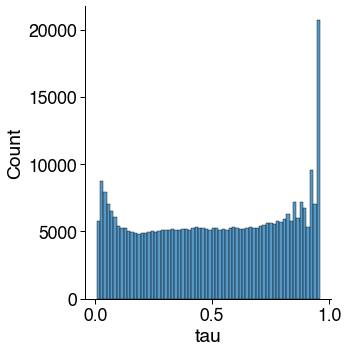

In [11]:
init_plot_settings(aspect='square')
sns.displot(tau_df, x='tau', kind='hist')

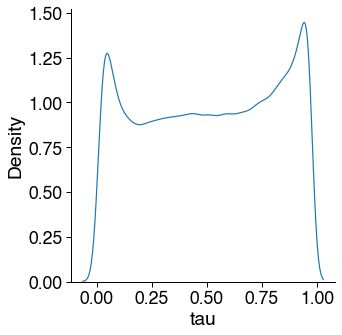

In [12]:
init_plot_settings(aspect='square')
sns.displot(tau_df, x='tau', kind='kde')

## get population-specific transcripts from PODER

In [13]:
# plot tau value vs. population specific transcripts
mt_df = pd.read_csv('../data/05_mastertable/poder_master_table_fixed_genics.tsv', sep='\t')
# mt_df = mt_df.loc[mt_df['filter']=='pass']
mt_df['pop_spec_t'] = (mt_df.population_sharing==1)&\
                      (mt_df.sample_sharing>1)

In [14]:
mt_df.head()

,isoform,geneid.v,associated_gene_biotype,proteinv47_Chromosome,proteinv47_Start,proteinv47_Stop,proteinv47_Strand,proteinv47_Source,proteinv47_CDS_Source,proteinv47_CDS_Start,...,CDS_genomic_end,predicted_NMD,perc_A_downstream_TTS,seq_A_downstream_TTS,ORF_seq,annotated,predicted_ORF,proteinv47_predicted_ORF,associated_gene_biotype_sub,pop_spec_t
0,ENST00000741425.1,ENSG00000296732.1,lncRNA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,35,TAAAGTTTTATAATCTTTTA,NaN,annotated,No ORF,No ORF,lncRNA,False
1,transcript_0,ENSG00000296732.1,lncRNA,GL000008.2,83369.0,130598.0,+,Cerberus,CPAT,83410.0,...,NaN,NaN,40,TAATGAGATTTATCAAAGGT,NaN,discovered,No ORF,Predicted ORF,lncRNA,False
2,transcript_1,ENSG00000296732.1,lncRNA,GL000008.2,83374.0,199915.0,+,Cerberus,CPAT,83410.0,...,NaN,NaN,35,GCAGCAAAATTTTTAGAGCT,NaN,discovered,No ORF,Predicted ORF,lncRNA,False
3,transcript_10,ENSG00000296732.1,lncRNA,GL000008.2,83404.0,199887.0,+,Cerberus,CPAT,83410.0,...,NaN,NaN,25,TTGTCAGTCCTTGATTTAAA,NaN,discovered,No ORF,Predicted ORF,lncRNA,False
4,transcript_11,ENSG00000296732.1,lncRNA,GL000008.2,83376.0,88830.0,+,Cerberus,CPAT,83410.0,...,NaN,NaN,25,GTTTACTTGCTTAACTAAGT,NaN,discovered,No ORF,Predicted ORF,lncRNA,False


In [15]:
tau_df = tau_df.merge(mt_df[['isoform', 'pop_spec_t', 'associated_gene_biotype']], 
                      how='left', 
                      left_on='tid',
                      right_on='isoform')

In [16]:
tau_df.head()

,tid,tau,isoform,pop_spec_t,associated_gene_biotype
0,ENST00000000233.10,0.014637,NaN,NaN,NaN
1,ENST00000000412.8,0.013598,NaN,NaN,NaN
2,ENST00000000442.11,0.012769,NaN,NaN,NaN
3,ENST00000001008.6,0.028120,NaN,NaN,NaN
4,ENST00000001146.7,0.413573,NaN,NaN,NaN


In [17]:
tau_df.loc[tau_df.pop_spec_t.notnull()].head()

,tid,tau,isoform,pop_spec_t,associated_gene_biotype
61,ENST00000010132.6,0.082240,ENST00000010132.6,False,Protein Coding
80,ENST00000013894.3,0.171998,ENST00000013894.3,False,Protein Coding
155,ENST00000075120.12,0.043303,ENST00000075120.12,False,Protein Coding
172,ENST00000155093.8,0.258973,ENST00000155093.8,False,Protein Coding
176,ENST00000156084.8,0.098634,ENST00000156084.8,False,Protein Coding


In [18]:
tau_df['tau_pop_spec_t'] = tau_df.tau>=0.8

In [19]:
tau_df[['tau_pop_spec_t',
        'pop_spec_t', 'tid']].groupby(['pop_spec_t',
                                       'tau_pop_spec_t']).nunique()

tid
pop_spec_t tau_pop_spec_t       
False      False           49495
           True             1066
True       False             805
           True               46

In [20]:
tau_df['pop_spec_t'] = tau_df['pop_spec_t'].fillna('Absent from PODER') # these are the transcripts that are in GENCODE but not in our anotation

In [21]:
tau_df[['tid', 'pop_spec_t']].groupby('pop_spec_t').nunique()

,tid
pop_spec_t,
False,50561
True,851
Absent from PODER,333535


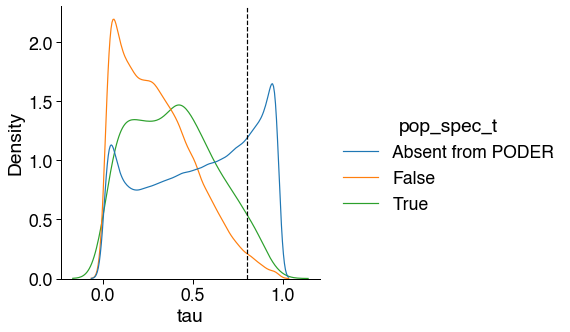

In [22]:
ax = sns.displot(tau_df, x='tau', hue='pop_spec_t', kind='kde',
            common_norm=False)
plt.axvline(0.8, color='k', linestyle='--')

In [23]:
# what are absent from PODER transcripts by gene biotype
bt_df = pd.read_csv('../data/v47_poder_merge_t_biotypes.tsv', sep='\t')
tau_df = tau_df.merge(bt_df, 
             how='left',
             left_on='tid',
             right_on='transcript_id')
tau_df.head()

,tid,tau,isoform,pop_spec_t,associated_gene_biotype,tau_pop_spec_t,transcript_id,gene_type
0,ENST00000000233.10,0.014637,NaN,Absent from PODER,NaN,False,ENST00000000233.10,protein_coding
1,ENST00000000412.8,0.013598,NaN,Absent from PODER,NaN,False,ENST00000000412.8,protein_coding
2,ENST00000000442.11,0.012769,NaN,Absent from PODER,NaN,False,ENST00000000442.11,protein_coding
3,ENST00000001008.6,0.028120,NaN,Absent from PODER,NaN,False,ENST00000001008.6,protein_coding
4,ENST00000001146.7,0.413573,NaN,Absent from PODER,NaN,False,ENST00000001146.7,protein_coding


In [24]:
tau_df[['tid', 'gene_type']].groupby('gene_type').nunique()
tau_df.loc[tau_df.associated_gene_biotype.isnull()&
           tau_df.gene_type.str.contains('IG')&
           tau_df.gene_type.str.contains('pseudogene'), 'associated_gene_biotype'] = 'Other'

tau_df.loc[tau_df.associated_gene_biotype.isnull()&
           tau_df.gene_type.str.contains('TR')&
           tau_df.gene_type.str.contains('pseudogene'), 'associated_gene_biotype'] = 'Other'

tau_df.loc[tau_df.associated_gene_biotype.isnull()&\
           tau_df.gene_type.str.contains('rRNA_pseudogene'), 'associated_gene_biotype'] = 'Other'

tau_df.loc[tau_df.associated_gene_biotype.isnull()&\
           tau_df.gene_type.str.contains('protein_coding'), 'associated_gene_biotype'] = 'Protein Coding'

tau_df.loc[tau_df.associated_gene_biotype.isnull()&\
           tau_df.gene_type.str.contains('lncRNA'), 'associated_gene_biotype'] = 'lncRNA'

tau_df.loc[tau_df.associated_gene_biotype.isnull()&
           tau_df.gene_type.str.contains('pseudogene'), 'associated_gene_biotype'] = 'Pseudogene'

tau_df.loc[tau_df.associated_gene_biotype.isnull(), 'associated_gene_biotype'] = 'Other'

tau_df.associated_gene_biotype.unique()

array(['Protein Coding', 'Pseudogene', 'lncRNA', 'Other',
       'Novel/Ambiguous Gene'], dtype=object)

In [25]:
tau_df.loc[tau_df.associated_gene_biotype.isnull(), 'gene_type'].unique()

array([], dtype=object)

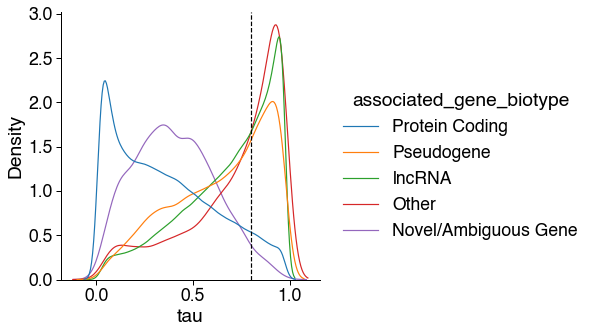

In [26]:
ax = sns.displot(tau_df, x='tau', hue='associated_gene_biotype', kind='kde',
            common_norm=False)
plt.axvline(0.8, color='k', linestyle='--')

In [29]:
tau_df.head()

,tid,tau,isoform,pop_spec_t,associated_gene_biotype,tau_pop_spec_t,transcript_id,gene_type
0,ENST00000000233.10,0.014637,NaN,Absent from PODER,Protein Coding,False,ENST00000000233.10,protein_coding
1,ENST00000000412.8,0.013598,NaN,Absent from PODER,Protein Coding,False,ENST00000000412.8,protein_coding
2,ENST00000000442.11,0.012769,NaN,Absent from PODER,Protein Coding,False,ENST00000000442.11,protein_coding
3,ENST00000001008.6,0.028120,NaN,Absent from PODER,Protein Coding,False,ENST00000001008.6,protein_coding
4,ENST00000001146.7,0.413573,NaN,Absent from PODER,Protein Coding,False,ENST00000001146.7,protein_coding


In [28]:
tau_df.to_csv('250213_mage_tau_biotype_pop_spec.tsv', sep='\t')

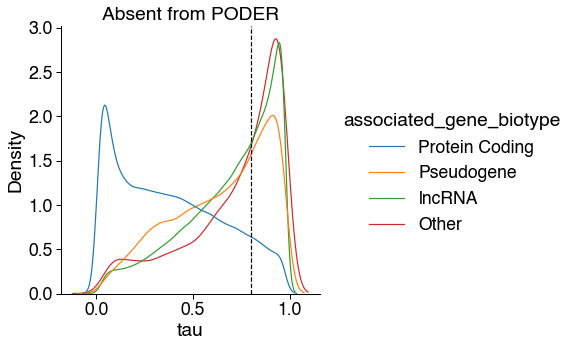

In [153]:
temp = tau_df.loc[tau_df.pop_spec_t == 'Absent from PODER']
ax = sns.displot(temp, x='tau', hue='associated_gene_biotype', kind='kde',
            common_norm=False)
plt.axvline(0.8, color='k', linestyle='--')
ax.set(title='Absent from PODER')

In [155]:
temp[['tid', 'associated_gene_biotype']].groupby('associated_gene_biotype').nunique()

,tid
associated_gene_biotype,
Other,5851
Protein Coding,159199
Pseudogene,12828
lncRNA,155657


In [157]:
tau_df[['tid', 'associated_gene_biotype']].groupby('associated_gene_biotype').nunique()

,tid
associated_gene_biotype,
Novel/Ambiguous Gene,2909
Other,5851
Protein Coding,202112
Pseudogene,12828
lncRNA,161247


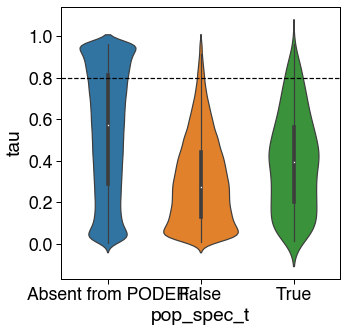

In [147]:
ax = sns.violinplot(tau_df, y='tau', x='pop_spec_t')
plt.axhline(0.8, color='k', linestyle='--')

In [148]:
# first, wilcoxon
 
# hypotheses are that absent transcripts, and pop_spec transcritps have higher tau values than non-pop-spec

for higher_cat in ['Absent from PODER', True]:
    # Split the data based on "pop_spec_t"
    x = tau_df[tau_df['pop_spec_t'] == higher_cat]['tau'] # these should be higher
    y = tau_df[tau_df['pop_spec_t'] == False]['tau'] # these should be lower

    # alt hypothesis is that y > x or x < y

    # ‘two-sided’: one of the distributions (underlying x or y) is stochastically greater than the other.

    # ‘less’:  x < y.

    # ‘greater’:  x > y.

    # do the test
    stat, p_value = st.ranksums(x, y,
                                alternative='greater')


    print(f'Hypoth: {higher_cat} transcripts tau > false pop-spec. disc. transcripts')
    print(f'Wilcoxon Rank Sum Test Statistic: {stat}')
    print(f'P-value: {p_value}')
    print()

Hypoth: Absent from PODER transcripts tau > false pop-spec. disc. transcripts
Wilcoxon Rank Sum Test Statistic: 165.63479257119968
P-value: 0.0

Hypoth: True transcripts tau > false pop-spec. disc. transcripts
Wilcoxon Rank Sum Test Statistic: 11.440308463599727
P-value: 1.3147448453267717e-30



In [149]:
## Fischer's exact test
# hypotheses are that absent transcripts and pop-spec disc. transcripts
# are enriched for pop-spec tau values in mage

for higher_cat in ['Absent from PODER', True]:
    temp = tau_df.loc[tau_df.pop_spec_t.isin([higher_cat, False])]

    temp = temp[['tau_pop_spec_t',
            'pop_spec_t', 'tid']].groupby(['pop_spec_t',
                                           'tau_pop_spec_t']).nunique().reset_index()

    temp.head()
    temp = temp.pivot(index='tau_pop_spec_t',
                      values = 'tid',
                      columns = 'pop_spec_t')
    temp = temp.values
    temp
    # Perform Fisher's Exact Test
    odds_ratio, p_value = st.fisher_exact(temp, alternative='greater')


    # # get the CI of these results
    # result = st.contingency.odds_ratio(temp, kind='conditional')
    # odds_ratio_value = result.statistic
    # confidence_interval = result.confidence_interval(confidence_level=0.95)

    print(f'Hypoth: {higher_cat} transcripts are enriched in pop-spec called by expression')
    print("Odds Ratio:", odds_ratio)
    print("P-value:", p_value)
    print()
    # print("Conditional Odds Ratio:", odds_ratio_value)
    # print("95% Confidence Interval:", confidence_interval)

Hypoth: Absent from PODER transcripts are enriched in pop-spec called by expression
Odds Ratio: 16.50747710694649
P-value: 0.0

Hypoth: True transcripts are enriched in pop-spec called by expression
Odds Ratio: 2.6531760922004826
P-value: 2.0673072274775012e-08

